In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers,Sequential
import matplotlib.pyplot as plt

In [ ]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('/content/drive/MyDrive/ctscan',shuffle=True,
                                                              batch_size=32, 
                                                              image_size=(256,256),)

Found 2481 files belonging to 2 classes.


In [ ]:
classnames=dataset.class_names
classnames

['COVID', 'non-COVID']

In [ ]:
len(dataset)

78

tf.Tensor(1, shape=(), dtype=int32)


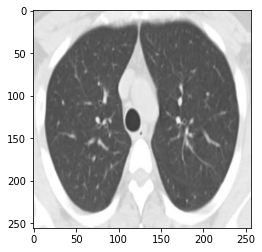

In [ ]:
for image_batch,label_batch in dataset.take(1):
  print(label_batch[0])
  plt.imshow(image_batch[0].numpy().astype("uint8"))

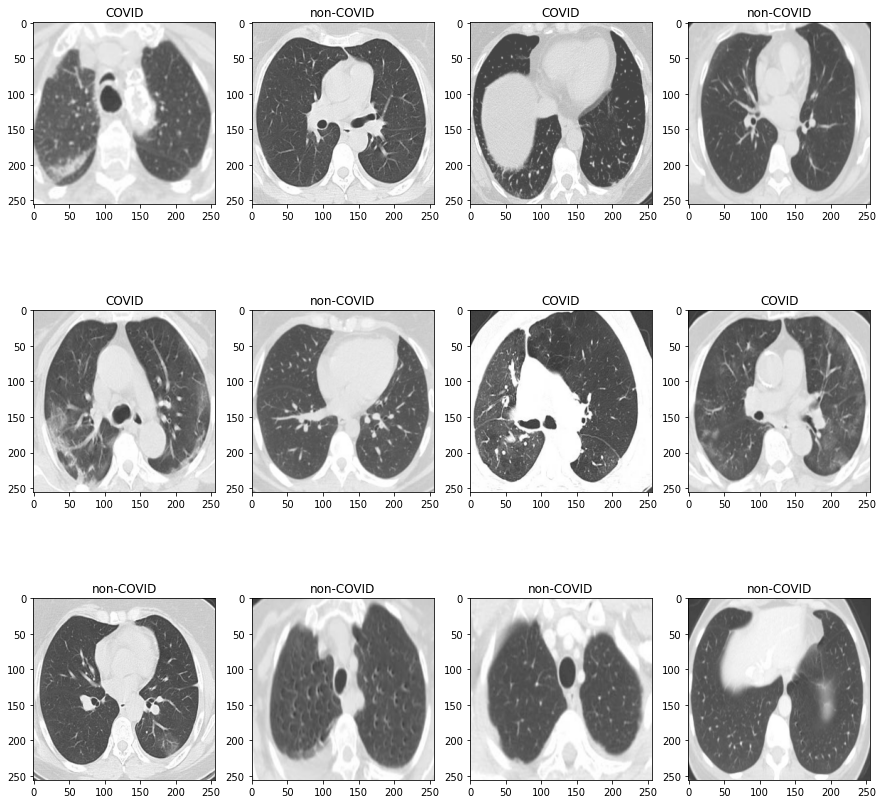

In [ ]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(classnames[labels_batch[i]])
      

In [ ]:
def train_test_split(dataset, train_size=0.8,val_size=0.1,test_size=0.1):
  train_df=dataset.take(int(train_size*len(dataset)))
  test=dataset.skip(int(train_size*len(dataset)))
  val_df=test.take(int(val_size*len(dataset)))
  test_df=test.skip(int(val_size*len(dataset)))
  return train_df,val_df,test_df

In [ ]:
train_df,val_df,test_df=train_test_split(dataset)

In [ ]:
len(train_df),len(val_df),len(test_df)

(62, 7, 9)

In [ ]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_df = val_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale= tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(255,255),
  layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_df = train_df.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
input_shape = (32, 255,255, 3)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 255, 255, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 253, 253, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 126, 126, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 124, 124, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_df,batch_size=32,validation_data=val_df,verbose=1,epochs=50)

Epoch 1/50
62/62 [==============================] - 202s 747ms/step - loss: 0.6945 - accuracy: 0.5005 - val_loss: 0.6890 - val_accuracy: 0.6071
Epoch 2/50
62/62 [==============================] - 21s 336ms/step - loss: 0.6775 - accuracy: 0.5711 - val_loss: 0.6082 - val_accuracy: 0.7232
Epoch 3/50
62/62 [==============================] - 20s 328ms/step - loss: 0.6333 - accuracy: 0.6522 - val_loss: 0.6005 - val_accuracy: 0.7411
Epoch 4/50
62/62 [==============================] - 20s 327ms/step - loss: 0.6066 - accuracy: 0.6618 - val_loss: 0.5874 - val_accuracy: 0.6920
Epoch 5/50
62/62 [==============================] - 20s 327ms/step - loss: 0.5853 - accuracy: 0.6961 - val_loss: 0.6044 - val_accuracy: 0.6964
Epoch 6/50
62/62 [==============================] - 20s 323ms/step - loss: 0.5421 - accuracy: 0.7308 - val_loss: 0.6151 - val_accuracy: 0.5982
Epoch 7/50
62/62 [==============================] - 20s 326ms/step - loss: 0.6050 - accuracy: 0.6905 - val_loss: 0.6325 - val_accuracy: 0.620

In [ ]:
model.save('model_cnn1.h5')


In [ ]:
final_loss, final_accuracy = model.evaluate(test_df)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

In [ ]:
model.save('model_cnn1.h5')